In [1]:
!pip install datasets soundfile speechbrain accelerate
!pip install torch==2.7.0+cu126 torchaudio==2.7.0 --index-url https://download.pytorch.org/whl/cu126
!pip install transformers

Looking in indexes: https://download.pytorch.org/whl/cu126


In [2]:
import torch, torchaudio
import transformers
import torch.nn as nn
import torch.nn.functional as F
import soundfile as sf
import io

from torch.utils.data import DataLoader, Dataset
from datasets import load_dataset, Audio
from tqdm import tqdm

In [3]:
print(torch.__version__)
print("Transformers version:", transformers.__version__)

2.7.0+cu126
Transformers version: 4.57.3


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cuda":
    print("CUDA is available")
else:
    print("CUDA is not available")  

CUDA is available


In [5]:
dataset = load_dataset("openslr/librispeech_asr", "clean", split="train.100[:3000]")
dataset = dataset.cast_column("audio", Audio(sampling_rate=16000, decode=False))

Resolving data files:   0%|          | 0/48 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/48 [00:00<?, ?it/s]

In [6]:
dataset[0]

{'file': '/home/albert/.cache/huggingface/datasets/downloads/extracted/bc0d9a6ef85c2d487c9c6efbc91f8892df927c69d3f80545a668cc058d5f677e/374-180298-0000.flac',
 'audio': {'bytes': b'fLaC\x00\x00\x00"\x10\x00\x10\x00\x00\x04\xa4\x00\x16\xc5\x03\xe8\x00\xf0\x00\x03\x8c \xbc\x9b)\\H\xbe6\xbe\xc0\xad\xc8H\x9a\xa8N^\x03\x00\x00$\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x10\x00\x00\x00\x00\x00\x00\x02p\x00\x00\x00\x00\x00\x00\x02j\xeb\x10\x00\x04\x00\x00( \x00\x00\x00reference libFLAC 1.2.1 20070917\x00\x00\x00\x00\x81\x00 \x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x0

In [7]:
from collections import defaultdict

speaker_counts = defaultdict(int)

for speaker_id in dataset["speaker_id"]:
    speaker_counts[speaker_id] += 1
print(speaker_counts)

defaultdict(<class 'int'>, {374: 113, 7800: 115, 2514: 108, 3240: 127, 1088: 112, 5456: 112, 5750: 122, 1246: 117, 8238: 123, 1263: 109, 7505: 115, 587: 117, 226: 107, 1743: 103, 4214: 81, 5789: 112, 7635: 122, 5390: 116, 307: 124, 7447: 114, 4362: 107, 6529: 107, 233: 110, 3242: 123, 1624: 101, 4297: 111, 6181: 72})


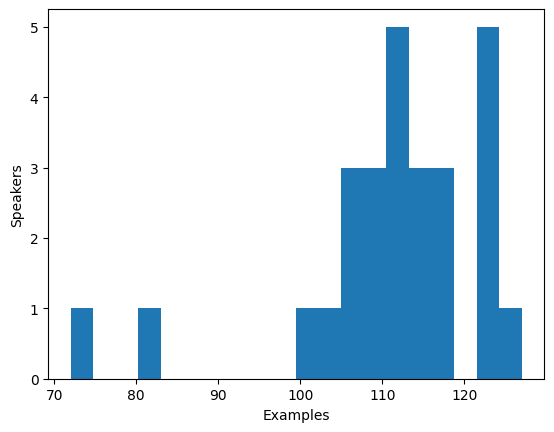

In [8]:
# code from https://huggingface.co/learn/audio-course/chapter6/fine-tuning 
import matplotlib.pyplot as plt

plt.figure()
plt.hist(speaker_counts.values(), bins=20)
plt.ylabel("Speakers")
plt.xlabel("Examples")
plt.show()

In [9]:
def select_speaker(speaker_id):
    return 100 <= speaker_counts[speaker_id] <= 400

dataset = dataset.filter(select_speaker, input_columns=["speaker_id"])
print(f"Number of Speakers: {len(set(dataset['speaker_id']))}")
print(f"Number of Samples: {len(dataset)}")

Number of Speakers: 25
Number of Samples: 2847


In [10]:
# code from https://huggingface.co/learn/audio-course/chapter6/fine-tuning 
from transformers import SpeechT5Processor, SpeechT5ForTextToSpeech
import torch

model_name = "microsoft/speecht5_tts"

# load model/processor
processor = SpeechT5Processor.from_pretrained(model_name)
model = SpeechT5ForTextToSpeech.from_pretrained(model_name).to(device)

In [11]:
# remove audio clips under 3 seconds
def audio_long_enough(audio):
    with io.BytesIO(audio["bytes"]) as f:
        audio_array, _ = sf.read(f)
    return len(audio_array) >= 48000 

# code from https://huggingface.co/learn/audio-course/chapter6/fine-tuning 
def is_not_too_long(batch):
    tokens = processor.tokenizer(batch["text"]) # tokenize
    return len(tokens["input_ids"]) < 200

dataset = dataset.filter(audio_long_enough, input_columns=["audio"])
dataset = dataset.filter(is_not_too_long)
len(dataset)

1307

In [12]:
# limit samples per speaker
SAMPLES_PER_SPEAKER = 5
samples_taken = defaultdict(int)

def samples_per_speaker(speaker_id):
    if samples_taken[speaker_id] < SAMPLES_PER_SPEAKER:
        samples_taken[speaker_id] += 1
        return True
    return False

dataset = dataset.filter(samples_per_speaker, input_columns=["speaker_id"])
print(f"Final Dataset Size: {len(dataset)}")

Final Dataset Size: 125


In [13]:
# code from https://huggingface.co/learn/audio-course/chapter6/fine-tuning 
import os
import torch
from speechbrain.inference.classifiers import EncoderClassifier
from accelerate import Accelerator

spk_model_name = "speechbrain/spkrec-xvect-voxceleb"
device = Accelerator().device
speaker_model = EncoderClassifier.from_hparams(
    source=spk_model_name,
    run_opts={"device": device},
    savedir=os.path.join("/tmp", spk_model_name),
)


def create_speaker_embedding(waveform):
    with torch.no_grad():
        speaker_embeddings = speaker_model.encode_batch(torch.tensor(waveform))
        speaker_embeddings = torch.nn.functional.normalize(speaker_embeddings, dim=2)
        speaker_embeddings = speaker_embeddings.squeeze().cpu().numpy()
    return speaker_embeddings

C:\Users\Irfan\miniconda3\envs\voiceclone\lib\site-packages\speechbrain\utils\autocast.py:188: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  wrapped_fwd = torch.cuda.amp.custom_fwd(fwd, cast_inputs=cast_inputs)
C:\Users\Irfan\miniconda3\envs\voiceclone\lib\inspect.py:746: UserWarning: Module 'speechbrain.pretrained' was deprecated, redirecting to 'speechbrain.inference'. Please update your script. This is a change from SpeechBrain 1.0. See: https://github.com/speechbrain/speechbrain/releases/tag/v1.0.0
  if ismodule(module) and hasattr(module, '__file__'):
C:\Users\Irfan\miniconda3\envs\voiceclone\lib\site-packages\speechbrain\utils\parameter_transfer.py:234: UserWarning: Requested Pretrainer collection using symlinks on Windows. This might not work; see `LocalStrategy` documentation. Consider unsetting `collect_in` in Pretrainer to avoid symlinking altogether.
  warnings.warn(


In [14]:
unique_speakers = sorted(list(set(dataset['speaker_id'])))
speaker2idx = {original_id: i for i, original_id in enumerate(unique_speakers)}
num_speakers = len(unique_speakers)

# map indexes from 0 to number of unique speakers
def map_speaker_ids(example):
    example['speaker_idx'] = speaker2idx[example['speaker_id']]
    return example
dataset = dataset.map(map_speaker_ids)

print(f"Mapped {num_speakers} speakers to indices 0-{num_speakers-1}")

Mapped 25 speakers to indices 0-24


In [15]:
# code from https://huggingface.co/learn/audio-course/chapter6/fine-tuning 
def prepare_dataset(example):
    print(example["audio"]["path"])
    with io.BytesIO(example["audio"]["bytes"]) as f:
        audio_array, sr = sf.read(f)

    example = processor(
        text=example["text"],
        audio_target=audio_array,
        sampling_rate=sr,
        return_attention_mask=False,
    )

    # strip off the batch dimension
    example["labels"] = example["labels"][0]

    # use SpeechBrain to obtain x-vector
    example["speaker_embeddings"] = create_speaker_embedding(audio_array)

    return example

In [16]:
cols_to_remove = ["audio", "file", "text", "speaker_id", "chapter_id", "id"]
dataset = dataset.map(prepare_dataset, remove_columns=cols_to_remove)

In [17]:
from datasets import ClassLabel
# dataset = dataset.train_test_split(test_size=0.1)

dataset = dataset.cast_column("speaker_idx", ClassLabel(num_classes=25))
dataset = dataset.train_test_split(test_size=0.2, stratify_by_column="speaker_idx")
print("Unique speakers in Test:", len(set(dataset['test']['speaker_idx'])))

Unique speakers in Test: 25


In [18]:
dataset['train']

Dataset({
    features: ['speaker_idx', 'input_ids', 'labels', 'speaker_embeddings'],
    num_rows: 100
})

In [19]:
import torch.nn as nn

all_indices = torch.tensor(dataset['train']['speaker_idx']).to(device)
all_embeddings = torch.tensor(dataset['train']['speaker_embeddings']).to(device)

# sum all embeddings for each speaker index
embedding_sums = torch.zeros(num_speakers, 512).to(device)
embedding_sums.index_add_(0, all_indices, all_embeddings)

# count samples per speaker
counts = torch.bincount(all_indices, minlength=num_speakers).float().unsqueeze(1).to(device)
counts = counts.clamp(min=1.0) # avoid division by zero

# calculate averages and add to speaker bank
average_embeddings = embedding_sums / counts
speaker_bank = nn.Embedding.from_pretrained(average_embeddings, freeze=False) # create embedding layer

print("Speaker bank initialized.")

Speaker bank initialized.


In [20]:
# code from https://huggingface.co/learn/audio-course/chapter6/fine-tuning 
from dataclasses import dataclass
from typing import Any, Dict, List, Union

@dataclass
class TTSDataCollatorWithPadding:
    processor: Any

    def __call__(self, features: list[dict[str, Union[list[int], torch.Tensor]]]) -> dict[str, torch.Tensor]:
        input_ids = [{"input_ids": feature["input_ids"]} for feature in features]
        label_features = [{"input_values": feature["labels"]} for feature in features]

        ### collect speaker indicies ###
        speaker_indices = [feature["speaker_idx"] for feature in features]

        # collate the inputs and targets into a batch
        batch = processor.pad(input_ids=input_ids, labels=label_features, return_tensors="pt")

        # replace padding with -100 to ignore loss correctly
        batch["labels"] = batch["labels"].masked_fill(batch.decoder_attention_mask.unsqueeze(-1).ne(1), -100)

        # not used during fine-tuning
        del batch["decoder_attention_mask"]

        # round down target lengths to multiple of reduction factor
        if model.config.reduction_factor > 1:
            target_lengths = torch.tensor([len(feature["input_values"]) for feature in label_features])
            target_lengths = target_lengths.new(
                [length - length % model.config.reduction_factor for length in target_lengths]
            )
            max_length = max(target_lengths)
            batch["labels"] = batch["labels"][:, :max_length]

        ### add speaker indicies to batch ###
        batch["speaker_idxs"] = torch.tensor(speaker_indices, dtype=torch.long)

        return batch

In [21]:
data_collator = TTSDataCollatorWithPadding(processor=processor)

In [22]:
# freeze model parameters
for param in model.parameters():
    param.requires_grad = False
model.eval() # disable dropout

SpeechT5ForTextToSpeech(
  (speecht5): SpeechT5Model(
    (encoder): SpeechT5EncoderWithTextPrenet(
      (prenet): SpeechT5TextEncoderPrenet(
        (embed_tokens): Embedding(81, 768, padding_idx=1)
        (encode_positions): SpeechT5ScaledPositionalEncoding(
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (wrapped_encoder): SpeechT5Encoder(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (layers): ModuleList(
          (0-11): 12 x SpeechT5EncoderLayer(
            (attention): SpeechT5Attention(
              (k_proj): Linear(in_features=768, out_features=768, bias=True)
              (v_proj): Linear(in_features=768, out_features=768, bias=True)
              (q_proj): Linear(in_features=768, out_features=768, bias=True)
              (out_proj): Linear(in_features=768, out_features=768, bias=True)
            )
            (dropout): Dropout(p=0.1, inplace=False)
     

### Fine-Tune Embedding

Optimizing speaker embeddings...


Epoch 1/10: 100%|█████████████████████████████████████████████████████████████████████████████████| 13/13 [00:08<00:00,  1.49it/s, loss=0.5257]


Epoch 1 Average Loss: 0.51106


Epoch 2/10: 100%|█████████████████████████████████████████████████████████████████████████████████| 13/13 [00:08<00:00,  1.55it/s, loss=0.4984]


Epoch 2 Average Loss: 0.49840


Epoch 3/10: 100%|█████████████████████████████████████████████████████████████████████████████████| 13/13 [00:08<00:00,  1.55it/s, loss=0.4550]


Epoch 3 Average Loss: 0.49385


Epoch 4/10: 100%|█████████████████████████████████████████████████████████████████████████████████| 13/13 [00:08<00:00,  1.55it/s, loss=0.4872]


Epoch 4 Average Loss: 0.49436


Epoch 5/10: 100%|█████████████████████████████████████████████████████████████████████████████████| 13/13 [00:08<00:00,  1.54it/s, loss=0.5675]


Epoch 5 Average Loss: 0.49210


Epoch 6/10: 100%|█████████████████████████████████████████████████████████████████████████████████| 13/13 [00:08<00:00,  1.55it/s, loss=0.4850]


Epoch 6 Average Loss: 0.48826


Epoch 7/10: 100%|█████████████████████████████████████████████████████████████████████████████████| 13/13 [00:08<00:00,  1.58it/s, loss=0.4564]


Epoch 7 Average Loss: 0.48588


Epoch 8/10: 100%|█████████████████████████████████████████████████████████████████████████████████| 13/13 [00:08<00:00,  1.54it/s, loss=0.4476]


Epoch 8 Average Loss: 0.48263


Epoch 9/10: 100%|█████████████████████████████████████████████████████████████████████████████████| 13/13 [00:08<00:00,  1.58it/s, loss=0.4823]


Epoch 9 Average Loss: 0.48113


Epoch 10/10: 100%|████████████████████████████████████████████████████████████████████████████████| 13/13 [00:08<00:00,  1.56it/s, loss=0.4231]

Epoch 10 Average Loss: 0.47827
Training Complete.


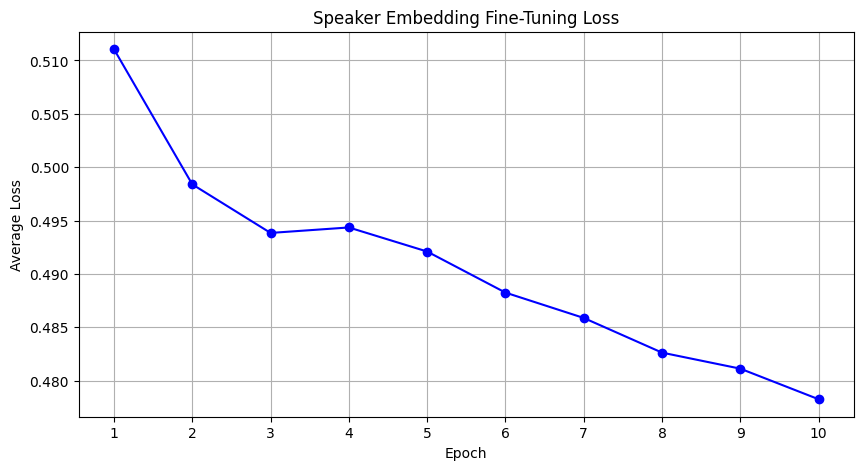

In [23]:
import matplotlib.pyplot as plt

lr = 1e-4
num_epochs = 10
batch_size = 8
optimizer = torch.optim.Adam(speaker_bank.parameters(), lr=lr)

train_loader = DataLoader(
    dataset['train'],
    batch_size=batch_size,
    shuffle=True, 
    collate_fn=data_collator
)

print("Optimizing speaker embeddings...")

# store loss values
epoch_losses = []

for epoch in range(num_epochs):
    total_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    
    for batch in progress_bar:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        speaker_idxs = batch["speaker_idxs"].to(device)

        optimizer.zero_grad()
        
        # get embeddings for speaker
        current_embeddings = speaker_bank(speaker_idxs)
        
        # forward pass
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            speaker_embeddings=current_embeddings,
            labels=labels
        )
        loss = outputs.loss
        
        # backward pass
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        progress_bar.set_postfix({"loss": f"{loss.item():.4f}"})

    # store average loss
    avg_loss = total_loss / len(train_loader)
    epoch_losses.append(avg_loss)
    
    print(f"Epoch {epoch+1} Average Loss: {avg_loss:.5f}")

# save the bank
torch.save(speaker_bank.state_dict(), "speaker_embeddings_ft.pt")
print("Training Complete.")

# 3. Plot the Learning Curve
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o', linestyle='-', color='b')
plt.title('Speaker Embedding Fine-Tuning Loss')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.grid(True)
plt.xticks(range(1, num_epochs + 1))
plt.show()

In [24]:
# load embedding weights from file

# speaker_bank = nn.Embedding(num_speakers, embedding_dim)
# state = torch.load("speaker_embeddings_ft.pt", map_location=device)
# speaker_bank.load_state_dict(state)
# speaker_bank = speaker_bank.to(device)

In [25]:
test_sample = dataset['test'][3]
speaker_idx_val = test_sample['speaker_idx']
# decode text
tokens = processor.batch_decode(test_sample["input_ids"])
text = "".join([" " if t == "" else t for t in tokens if t != "</s>"])[1:]
print(text)

# original vs fine-tuned embeddings
original_emb = torch.tensor(test_sample['speaker_embeddings']).to(device).unsqueeze(0)
tuned_emb = speaker_bank(torch.tensor(speaker_idx_val).to(device)).unsqueeze(0) # get embedding for specific speaker

print(f"Comparing Speaker Index: {speaker_idx_val}")
print(f"Original Embedding Norm: {torch.norm(original_emb).item():.4f}")
print(f"Tuned Embedding Norm:    {torch.norm(tuned_emb).item():.4f}")

THE FIRST RAINS HAD FALLEN ON THE LOWLANDS AND THE FIRST SNOWS ON THE MOUNTAINS AND EVERYTHING WAS FRESH AND BRACING WHILE AN ABUNDANCE OF BALMY SUNSHINE FILLED ALL THE NOONDAY HOURS
Comparing Speaker Index: 14
Original Embedding Norm: 1.0000
Tuned Embedding Norm:    0.9944


In [26]:
inputs = processor(text=text, return_tensors="pt").to(device)

# spectrogram comparison
spec_ground_truth = torch.tensor(test_sample["labels"]).to(device)
spec_orig = model.generate_speech(inputs["input_ids"], original_emb)
spec_tuned = model.generate_speech(inputs["input_ids"], tuned_emb)

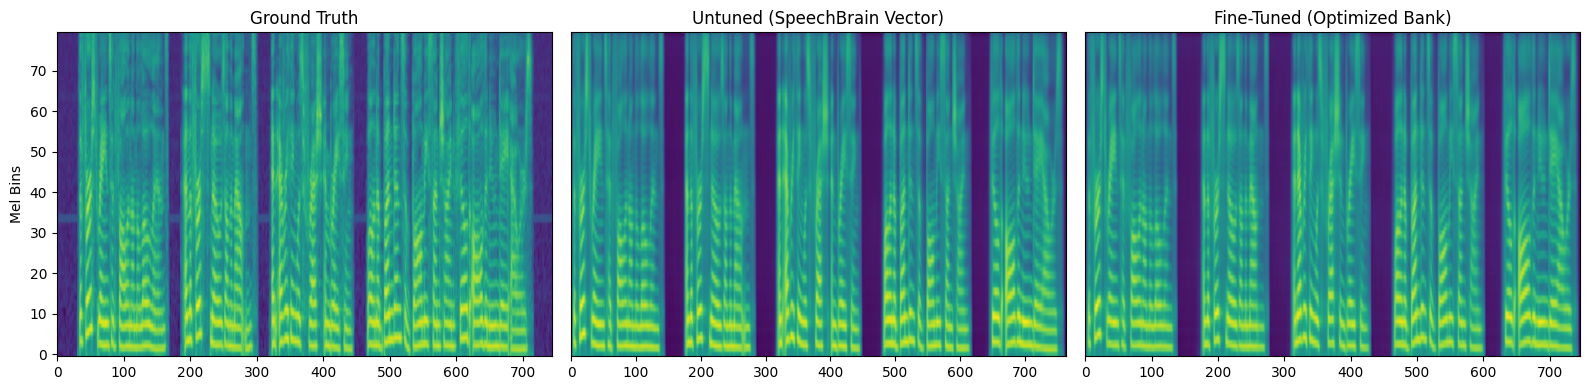

In [27]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(16, 4))

# ground truth
axs[0].imshow(spec_ground_truth.cpu().T, origin="lower", aspect="auto")
axs[0].set_title("Ground Truth")
axs[0].set_ylabel("Mel Bins")

# original embedding
axs[1].imshow(spec_orig.cpu().T, origin="lower", aspect="auto")
axs[1].set_title("Untuned (SpeechBrain Vector)")
axs[1].set_yticks([])

# fine-tuned embedding
axs[2].imshow(spec_tuned.cpu().T, origin="lower", aspect="auto")
axs[2].set_title("Fine-Tuned (Optimized Bank)")
axs[2].set_yticks([])

plt.tight_layout()
plt.show()

In [28]:
from IPython.display import Audio
from transformers import SpeechT5HifiGan
vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan").to(device)

print("Playing Original Ground Truth Audio:")
ground_truth_audio = vocoder(spec_ground_truth.unsqueeze(0))
Audio(ground_truth_audio.detach().cpu().numpy(), rate=16000)

Playing Original Ground Truth Audio:


In [29]:
print("Playing SpeechBrain Version:")
orig_audio = vocoder(spec_orig.unsqueeze(0))
Audio(orig_audio.detach().cpu().numpy(), rate=16000)

Playing SpeechBrain Version:


In [30]:
print("Playing Tuned Version:")
tuned_audio = vocoder(spec_tuned.unsqueeze(0))
Audio(tuned_audio.detach().cpu().numpy(), rate=16000)

Playing Tuned Version:


In [31]:
def load_audio_librosa(path, target_sr=None):

    y, sr = librosa.load(path, sr=target_sr)  # mono
    wav = torch.from_numpy(y).unsqueeze(0)    # (1, T)
    return wav, sr

def compute_speaker_similarity_ecapa(audio_a, audio_b):

    classifier = EncoderClassifier.from_hparams(
    source="speechbrain/spkrec-ecapa-voxceleb",
    run_opts={"device": device},
)

    # ECAPA model expects 16kHz mono
    # take in audio directly
    wav_a = audio_a.detach().squeeze().unsqueeze(0).to(device)
    wav_b = audio_b.detach().squeeze().unsqueeze(0).to(device)

    with torch.no_grad():
        emb_a = classifier.encode_batch(wav_a).squeeze(0)
        emb_b = classifier.encode_batch(wav_b).squeeze(0)

    if emb_a.ndim == 2:
        emb_a = emb_a.mean(dim=0)
    if emb_b.ndim == 2:
        emb_b = emb_b.mean(dim=0)

    emb_a = emb_a / emb_a.norm(p=2)
    emb_b = emb_b / emb_b.norm(p=2)

    cos_sim = F.cosine_similarity(
        emb_a.unsqueeze(0), emb_b.unsqueeze(0)
    ).item()

    return cos_sim

In [32]:
score = compute_speaker_similarity_ecapa(ground_truth_audio, tuned_audio)
print(f"Tuned Similarity Score: {score:.4f}")
score = compute_speaker_similarity_ecapa(ground_truth_audio, orig_audio)
print(f"SpeechBrain Similarity Score: {score:.4f}")

Tuned Similarity Score: 0.7165
SpeechBrain Similarity Score: 0.8035


In [33]:
from jiwer import wer

def load_asr_model():
    bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H
    model = bundle.get_model().to(device)
    labels = bundle.get_labels()
    return model, labels, bundle.sample_rate


def greedy_decode(emissions, labels):

    indices = torch.argmax(emissions, dim=-1)  # (batch, time)
    transcripts = []

    for inds in indices:
        prev = None
        tokens = []
        for i in inds:
            i = i.item()
            if i != 0 and i != prev:  # 0 = blank
                tokens.append(labels[i])
            prev = i
        transcripts.append("".join(tokens).replace("|", " ").strip())
    return transcripts


def transcribe_audio(wav, model, labels, asr_sr):

    with torch.no_grad():
        emissions, _ = model(wav)
        emissions = torch.log_softmax(emissions, dim=-1)

    text = greedy_decode(emissions.cpu(), labels)[0]
    return text


def compute_wer(reference_text, hyp_text):
    ref = reference_text.lower().strip()
    hyp = hyp_text.lower().strip()
    return wer(ref, hyp)


In [34]:
 # ASR + WER
print("Loading ASR model (Wav2Vec2)...")
asr_model, asr_labels, asr_sr = load_asr_model()

print("Transcribing original audio...")
orig_asr = transcribe_audio(ground_truth_audio, asr_model, asr_labels, asr_sr)
print(f"ASR (original): {orig_asr}")

print("Transcribing TTS/test audio...")
tts_asr = transcribe_audio(tuned_audio, asr_model, asr_labels, asr_sr)
print(f"ASR (TTS):      {tts_asr}")
print()

print("Transcribing SpeechBrain/test audio...")
spb_asr = transcribe_audio(orig_audio, asr_model, asr_labels, asr_sr)
print(f"ASR (TTS):      {tts_asr}")
print()

orig_wer_val = compute_wer(text, orig_asr)
tts_wer_val = compute_wer(text, tts_asr)
spb_wer_val = compute_wer(text, spb_asr)

print(f"WER (original audio): {orig_wer_val:.4f}")
print(f"WER (TTS/test audio): {tts_wer_val:.4f}")
print(f"WER (SPB/test audio): {spb_wer_val:.4f}")

Loading ASR model (Wav2Vec2)...
Transcribing original audio...
ASR (original): THE FIRST RAINS HAD FALLEN ON THE LOWLANDS AND THE FIRST SNOWS ON THE MOUNTAINS AND EVERYTHING WAS FRESH AND BRACING WHILE AN ABUNDANCE OF BALMY SUNSHINE FILLED ALL THE NOONDAY HOURS
Transcribing TTS/test audio...
ASR (TTS):      THE FIRST RAINS HAD FALLEN ON THE LOWLANDS AND THE FIRST SNOWS ON THE MOUNTAINS AND EVERYTHING WAS FRESH AND BRACING WHILE IN ABUNDANCE OF BALMY SUNSHINE FILLED ALL THE NOON DAY HOURS

Transcribing SpeechBrain/test audio...
ASR (TTS):      THE FIRST RAINS HAD FALLEN ON THE LOWLANDS AND THE FIRST SNOWS ON THE MOUNTAINS AND EVERYTHING WAS FRESH AND BRACING WHILE IN ABUNDANCE OF BALMY SUNSHINE FILLED ALL THE NOON DAY HOURS

WER (original audio): 0.0000
WER (TTS/test audio): 0.0938
WER (SPB/test audio): 0.0938


In [35]:
import soundfile as sf
from transformers import SpeechT5HifiGan

vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan").to(device)

def save_to_flac(spectrogram, filename):
    with torch.no_grad():
        audio_tensor = vocoder(spectrogram.unsqueeze(0)) 
        sf.write(filename, audio_tensor.squeeze().cpu().numpy(), samplerate=16000)

In [36]:
# make folders
os.makedirs("./ground_truth", exist_ok=True)
os.makedirs("./fine_tuned", exist_ok=True)
os.makedirs("./speech_brain", exist_ok=True)

seen = set()
with open("./ground_truth/text.txt", "w") as f:
    pass

for i, sample in enumerate(dataset['test']):
    speaker = sample['speaker_idx']
    
    if speaker in seen:
        continue
    seen.add(speaker)
    
    tokens = processor.batch_decode(sample["input_ids"])
    text = "".join([" " if t == "" else t for t in tokens if t != "</s>"])[1:]
    with open("./ground_truth/text.txt", "a") as f:
        f.write(f"{speaker} {text}\n")

    # get speaker embeddings
    spb_emb = torch.tensor(sample['speaker_embeddings']).to(device).unsqueeze(0)
    tuned_emb = speaker_bank(torch.tensor(speaker).to(device)).unsqueeze(0)

    print(f"Generating audio files for speaker {speaker}...")
    inputs = processor(text=text, return_tensors="pt").to(device)
    # generate spectrograms
    gt_spec = torch.tensor(sample["labels"]).to(device)
    spb_spec = model.generate_speech(inputs["input_ids"], spb_emb)
    tuned_spec = model.generate_speech(inputs["input_ids"], tuned_emb)

    # save audio files
    save_to_flac(gt_spec, f"./ground_truth/{speaker}.flac")
    save_to_flac(tuned_spec, f"./fine_tuned/{speaker}.flac")
    save_to_flac(spb_spec, f"./speech_brain/{speaker}.flac")
    
    if len(seen) == 25:
        break

Generating audio files for speaker 4...
Generating audio files for speaker 17...
Generating audio files for speaker 5...
Generating audio files for speaker 14...
Generating audio files for speaker 7...
Generating audio files for speaker 16...
Generating audio files for speaker 13...
Generating audio files for speaker 8...
Generating audio files for speaker 9...
Generating audio files for speaker 20...
Generating audio files for speaker 10...
Generating audio files for speaker 18...
Generating audio files for speaker 1...
Generating audio files for speaker 24...
Generating audio files for speaker 15...
Generating audio files for speaker 22...
Generating audio files for speaker 12...
Generating audio files for speaker 0...
Generating audio files for speaker 19...
Generating audio files for speaker 3...
Generating audio files for speaker 23...
Generating audio files for speaker 2...
Generating audio files for speaker 6...
Generating audio files for speaker 21...
Generating audio files for

Loading reference transcripts...
Found 25 utterances in transcript file.
Loading ASR model (Wav2Vec2)...

Processing 4
Reference text: THEN HE AGAIN HELD CONVERSATION WITH MISS TEBBS WHO NODDED AND LOOKED SMILINGLY TOWARD NORA WHO STOOD SCOWLING FAINTLY RATHER ILL PLEASED AT ATTRACTING SO MUCH ATTENTION
Computing speaker similarity with ECAPA-TDNN...
ECAPA speaker similarity (cosine, -1 to 1, higher = more similar): 0.7088
Transcribing original audio...
ASR (original):  THEN HE AGAIN HELD CONVERSATION WITH MISS TEBBS WHO NODDED AND LOOKED SMILINGLY TOWARD NORA WHO STOOD SCOWLING FAINTLY RATHER ILL PLEASED AT ATTRACTING SO MUCH ATTENTION
Transcribing generated audio...
ASR (generated): THEN HE AGAIN HELD CONVERSATION WITH MISS TEBBS WHO NODDED AND LOOKED SMILINGLY TOWARD NORA PLEASED AT ATTRACTING SO MUCH ATTENTION
Transcribing generated audio...
ASR (generated): THEN HE AGAIN HELD CONVERSATION WITH MISS TEBBS WHO NODDED AND LOOKED SMILINGLY TOWARD NORA FAINTLY RATHER ILL PLEASED AT ATT

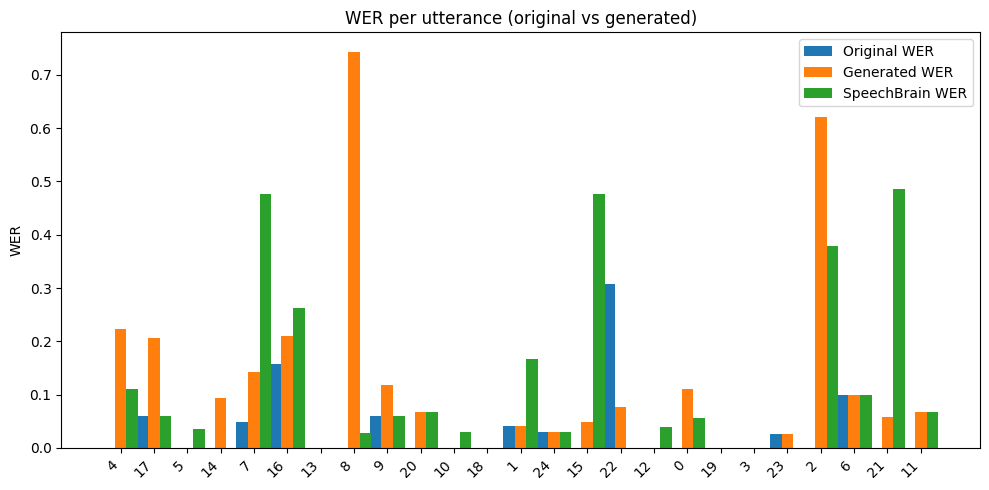

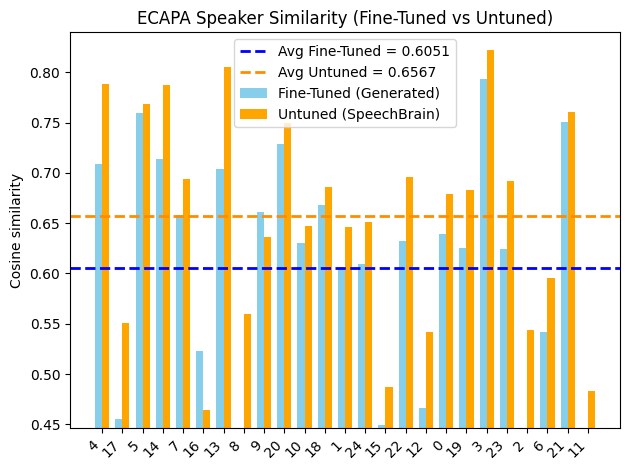

Saved 'wer_per_utterance.png' and 'ecapa_similarity_per_utterance.png'


In [37]:
%run pgm1-ECAPA.py